# Natural Language Processing for Apache Spark
- https://databricks.com/blog/2017/10/19/introducing-natural-language-processing-library-apache-spark.html
- https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/5722190290795989/2546946806099472/8175309257345795/latest.html
- https://www.youtube.com/watch?v=AsW0QzbYVow
- https://github.com/Maha41/Sentiment-analysis-on-Amazon-Reviews-using-Python/blob/master/Analysis/Analysis_1.ipynb

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7") # SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
# import os
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# !pwd
# os.chdir('gdrive/Shared drives/brazilian-ecommerce')
# !pwd
# !ls

## Step 1: Create spark session and Import necessary libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Step 2: Load olist order reviews.csv

In [0]:
# schema = StructType([
#     StructField("rating", IntegerType(), True),
#     StructField("date", StringType(), True),
#     StructField("variation", StringType(), True),
#     StructField("verified_reviews", StringType(), True),
#     StructField("feedback", IntegerType(), True)])

In [0]:
# https://docs.databricks.com/data/data-sources/read-csv.html
data_DF = spark.read.format("org.apache.spark.csv").option("header",True).option("mode", "PERMISSIVE").csv('/content/gdrive/Shared drives/brazilian-ecommerce/olist_order_reviews_dataset.csv')

In [0]:
data_DF.show()

+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+
|           review_id|            order_id|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|
+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+
|7bc2406110b926393...|73fc7af87114b3971...|           4|                null|                  null| 2018-01-18 00:00:00|    2018-01-18 21:46:59|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|                null|                  null| 2018-03-10 00:00:00|    2018-03-11 03:05:13|
|228ce5500dc1d8e02...|f9e4b658b201a9f2e...|           5|                null|                  null| 2018-02-17 00:00:00|    2018-02-18 14:36:24|
|e64fb393e7b32834b...|658677c97b385a9be...|           5|                null|  Recebi bem antes ...| 2017-04-21 00:00:00|   

In [0]:
data_DF.createOrReplaceTempView("data")

In [0]:
data_DF.show()

+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+
|           review_id|            order_id|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|
+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+
|7bc2406110b926393...|73fc7af87114b3971...|           4|                null|                  null| 2018-01-18 00:00:00|    2018-01-18 21:46:59|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|                null|                  null| 2018-03-10 00:00:00|    2018-03-11 03:05:13|
|228ce5500dc1d8e02...|f9e4b658b201a9f2e...|           5|                null|                  null| 2018-02-17 00:00:00|    2018-02-18 14:36:24|
|e64fb393e7b32834b...|658677c97b385a9be...|           5|                null|  Recebi bem antes ...| 2017-04-21 00:00:00|   

## Step 3: Fetch column: “review_comment_message” because we need only that column for extracting sentiments from customers and for that we need to convert our dataframe into RDD(best suited for processing unstructured data).

In [0]:
reviews_rdd = data_DF.select("review_comment_message").rdd.flatMap(lambda x: x)
reviews_rdd.collect()

[None,
 None,
 None,
 u'Recebi bem antes do prazo estipulado.',
 u'Parab\xe9ns lojas lannister adorei comprar pela Internet seguro e pr\xe1tico Parab\xe9ns a todos feliz P\xe1scoa',
 None,
 None,
 None,
 None,
 u'aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que \xe9 o mesmo aparelho',
 None,
 None,
 u'Mas um pouco ,travando...pelo valor ta Boa.',
 None,
 None,
 None,
 u'Vendedor confi\xe1vel, produto ok e entrega antes do prazo.',
 u'GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU',
 None,
 None,
 u'P\xe9ssimo',
 None,
 None,
 u'Loja nota 10',
 None,
 u'obrigado pela aten\xe7ao amim dispensada',
 None,
 None,
 u'A compra foi realizada facilmente.',
 None,
 None,
 None,
 u'rel\xf3gio muito bonito e barato.',
 u'N\xe3o gostei ! Comprei gato por lebre',
 None,
 None,
 u'Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredit

## Step 4: Remove header and convert all the data into lowercase for easy processing.

In [0]:
header = reviews_rdd.first()
data_rmv_col = reviews_rdd.filter(lambda row: row != header)

lowerCase_sentRDD = data_rmv_col.map(lambda x : x.lower())

## Step 5: Text data can be split into sentences and this process is called sentence tokenization.

In [0]:
def sent_TokenizeFunct(x):
    return nltk.sent_tokenize(x)
sentenceTokenizeRDD = lowerCase_sentRDD.map(sent_TokenizeFunct)

In [0]:
sentenceTokenizeRDD.collect()

[[u'recebi bem antes do prazo estipulado.'],
 [u'parab\xe9ns lojas lannister adorei comprar pela internet seguro e pr\xe1tico parab\xe9ns a todos feliz p\xe1scoa'],
 [u'aparelho eficiente.',
  u'no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que \xe9 o mesmo aparelho'],
 [u'mas um pouco ,travando...pelo valor ta boa.'],
 [u'vendedor confi\xe1vel, produto ok e entrega antes do prazo.'],
 [u'gostaria de saber o que houve, sempre recebi e essa compra agora me decpcionou'],
 [u'p\xe9ssimo'],
 [u'loja nota 10'],
 [u'obrigado pela aten\xe7ao amim dispensada'],
 [u'a compra foi realizada facilmente.'],
 [u'rel\xf3gio muito bonito e barato.'],
 [u'n\xe3o gostei !', u'comprei gato por lebre'],
 [u'sempre compro pela internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo m\xe1ximo.',
  u'no stark o prazo m\xe1ximo j\xe1 se esgotou e ainda n\xe3o recebi o produto.'],
 [u'recebi exatamente 

## Step 6: Now split each sentence into words, also called word tokenization.

In [0]:
def word_TokenizeFunct(x):
    splitted = [word for line in x for word in line.split()]
    return splitted
wordTokenizeRDD = sentenceTokenizeRDD.map(word_TokenizeFunct)

In [0]:
wordTokenizeRDD.collect()

[[u'recebi', u'bem', u'antes', u'do', u'prazo', u'estipulado.'],
 [u'parab\xe9ns',
  u'lojas',
  u'lannister',
  u'adorei',
  u'comprar',
  u'pela',
  u'internet',
  u'seguro',
  u'e',
  u'pr\xe1tico',
  u'parab\xe9ns',
  u'a',
  u'todos',
  u'feliz',
  u'p\xe1scoa'],
 [u'aparelho',
  u'eficiente.',
  u'no',
  u'site',
  u'a',
  u'marca',
  u'do',
  u'aparelho',
  u'esta',
  u'impresso',
  u'como',
  u'3desinfector',
  u'e',
  u'ao',
  u'chegar',
  u'esta',
  u'com',
  u'outro',
  u'nome...atualizar',
  u'com',
  u'a',
  u'marca',
  u'correta',
  u'uma',
  u'vez',
  u'que',
  u'\xe9',
  u'o',
  u'mesmo',
  u'aparelho'],
 [u'mas', u'um', u'pouco', u',travando...pelo', u'valor', u'ta', u'boa.'],
 [u'vendedor',
  u'confi\xe1vel,',
  u'produto',
  u'ok',
  u'e',
  u'entrega',
  u'antes',
  u'do',
  u'prazo.'],
 [u'gostaria',
  u'de',
  u'saber',
  u'o',
  u'que',
  u'houve,',
  u'sempre',
  u'recebi',
  u'e',
  u'essa',
  u'compra',
  u'agora',
  u'me',
  u'decpcionou'],
 [u'p\xe9ssimo'],


## Step 7: To move ahead first we will clean our data, here we’re gonna remove stopwords, punctuations and empty spaces.

In [0]:
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('portuguese'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence
stopwordRDD = wordTokenizeRDD.map(removeStopWordsFunct)

def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered
rmvPunctRDD = stopwordRDD.map(removePunctuationsFunct)

In [0]:
rmvPunctRDD.collect()

[[u'recebi', u'bem', u'antes', u'prazo', u'estipulado'],
 [u'parab\xe9ns',
  u'lojas',
  u'lannister',
  u'adorei',
  u'comprar',
  u'internet',
  u'seguro',
  u'pr\xe1tico',
  u'parab\xe9ns',
  u'todos',
  u'feliz',
  u'p\xe1scoa'],
 [u'aparelho',
  u'eficiente',
  u'site',
  u'marca',
  u'aparelho',
  u'impresso',
  u'3desinfector',
  u'chegar',
  u'outro',
  u'nomeatualizar',
  u'marca',
  u'correta',
  u'vez',
  u'aparelho'],
 [u'pouco', u'travandopelo', u'valor', u'ta', u'boa'],
 [u'vendedor',
  u'confi\xe1vel',
  u'produto',
  u'ok',
  u'entrega',
  u'antes',
  u'prazo'],
 [u'gostaria',
  u'saber',
  u'houve',
  u'sempre',
  u'recebi',
  u'compra',
  u'agora',
  u'decpcionou'],
 [u'p\xe9ssimo'],
 [u'loja', u'nota', u'10'],
 [u'obrigado', u'aten\xe7ao', u'amim', u'dispensada'],
 [u'compra', u'realizada', u'facilmente'],
 [u'rel\xf3gio', u'bonito', u'barato'],
 [u'gostei', '', u'comprei', u'gato', u'lebre'],
 [u'sempre',
  u'compro',
  u'internet',
  u'entrega',
  u'ocorre',
  u'an

## Step 8: Lemmatization
Stemming and Lemmatization are the basic text processing methods for English text. The goal of both of them is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. We have skipped Stemming because it is not an efficient method as sometimes it produces words that are not even close to the actual word.


In [0]:
def lemmatizationFunct(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem
lem_wordsRDD = rmvPunctRDD.map(lemmatizationFunct)

## Step 9: Our next task is a little tricky, we have to extract key phrases(also called Noun phrases). So first we need to join “lem_wordsRDD” tokens.

In [0]:
def joinTokensFunct(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x
joinedTokens = lem_wordsRDD.map(joinTokensFunct)

In [0]:
joinedTokens.collect()

[u'recebi bem ante prazo estipulado',
 u'parab\xe9ns lojas lannister adorei comprar internet seguro pr\xe1tico parab\xe9ns todos feliz p\xe1scoa',
 u'aparelho eficiente site marca aparelho impresso 3desinfector chegar outro nomeatualizar marca correta vez aparelho',
 u'pouco travandopelo valor ta boa',
 u'vendedor confi\xe1vel produto ok entrega ante prazo',
 u'gostaria saber houve sempre recebi compra agora decpcionou',
 u'p\xe9ssimo',
 u'loja nota 10',
 u'obrigado aten\xe7ao amim dispensada',
 u'compra realizada facilmente',
 u'rel\xf3gio bonito barato',
 u'gostei  comprei gato lebre',
 u'sempre compro internet entrega ocorre ante prazo combinado acredito ser prazo m\xe1ximo stark prazo m\xe1ximo esgotou ainda recebi produto',
 u'recebi exatamente esperava demais encomendas outros vendedores atrasaram chegou prazo',
 u'recomendo ',
 u'boa',
 u't\xf4 completamente apaixonada loja super respons\xe1vel confi\xe1vel',
 u'nada chegar pedido',
 u'bom cheiroso',
 u'otimo vendedor chegou ate

## Step 10: Extract key phrases, In the below code I’m doing chunking, chinking and POS tagging using Regular expression and extracting all the Noun phrases.
- Chunking: Also referred to as shallow parsing, is a task that follows Part-Of-Speech Tagging and that adds more structure to the sentence. The result is a grouping of the words in “chunks”.
- Chinking: Chinking is a lot like chunking, it is basically a way for you to remove a chunk from a chunk. The chunk that you remove from your chunk is your chink.
- POS tagging: A Part-Of-Speech Tagger (POS Tagger) is a piece of software that reads the text in some language and assigns parts of speech to each word (and other tokens), such as noun, verb, adjective, etc.

In [0]:
def extractPhraseFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('portuguese')) # stopwords.words('english') -> stopwords.words('portuguese')
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase
extractphraseRDD = joinedTokens.map(extractPhraseFunct)

In [0]:
extractphraseRDD.collect()

[[u'recebi bem ante prazo estipulado'],
 [u'parab\xe9ns lojas lannister adorei comprar internet seguro pr\xe1tico parab\xe9ns todos feliz p\xe1scoa'],
 [u'aparelho',
  u'site marca',
  u'chegar outro nomeatualizar marca correta vez aparelho'],
 [u'pouco travandopelo valor ta boa'],
 [u'vendedor confi\xe1vel produto ok entrega ante prazo'],
 [u'gostaria', u'sempre recebi compra agora decpcionou'],
 [u'p\xe9ssimo'],
 [u'loja'],
 [u'obrigado aten\xe7ao', u'dispensada'],
 [u'compra realizada facilmente'],
 [u'rel\xf3gio bonito barato'],
 [u'gostei comprei gato lebre'],
 [u'sempre compro internet entrega ocorre ante prazo combinado',
  u'ser prazo m\xe1ximo stark prazo m\xe1ximo esgotou ainda recebi produto'],
 [u'recebi exatamente', u'demais', u'outros vendedores', u'chegou prazo'],
 [u'recomendo'],
 [u'boa'],
 [u't\xf4 completamente apaixonada', u'respons\xe1vel confi\xe1vel'],
 [u'nada chegar pedido'],
 [u'bom cheiroso'],
 [u'otimo vendedor chegou ate ante prazo adorei produto'],
 [u'pro

## Step 11: From the above step we roughly got all the key phrases the customers are talking about. Now categorize these key phrases into positive, Negative or Neutral.
There are so many ways to get the sentiments, We used NLTK VADER you guys can choose any other method as per your interest.
https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [0]:
def sentimentWordsFunct(x):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
    
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))
    return sentiment_list
sentimentRDD = extractphraseRDD.map(sentimentWordsFunct)

In [0]:
sentimentRDD.collect()

[[(u'recebi bem ante prazo estipulado', 'Neutral')],
 [(u'parab\xe9ns lojas lannister adorei comprar internet seguro pr\xe1tico parab\xe9ns todos feliz p\xe1scoa',
   'Neutral')],
 [(u'aparelho', 'Neutral'),
  (u'site marca', 'Neutral'),
  (u'chegar outro nomeatualizar marca correta vez aparelho', 'Neutral')],
 [(u'pouco travandopelo valor ta boa', 'Neutral')],
 [(u'vendedor confi\xe1vel produto ok entrega ante prazo', 'Positive')],
 [(u'gostaria', 'Neutral'),
  (u'sempre recebi compra agora decpcionou', 'Neutral')],
 [(u'p\xe9ssimo', 'Neutral')],
 [(u'loja', 'Neutral')],
 [(u'obrigado aten\xe7ao', 'Neutral'), (u'dispensada', 'Neutral')],
 [(u'compra realizada facilmente', 'Neutral')],
 [(u'rel\xf3gio bonito barato', 'Neutral')],
 [(u'gostei comprei gato lebre', 'Neutral')],
 [(u'sempre compro internet entrega ocorre ante prazo combinado', 'Neutral'),
  (u'ser prazo m\xe1ximo stark prazo m\xe1ximo esgotou ainda recebi produto',
   'Neutral')],
 [(u'recebi exatamente', 'Neutral'),
  (u'

## Step 12: Now let's extract the top 20 keywords from the extracted key phrases.

In [0]:
freqDistRDD = extractphraseRDD.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

In [0]:
freqDistRDD.take(20)

[(u'bom', 1081),
 (u'recomendo', 727),
 (u'produto', 535),
 (u'comprei', 401),
 (u'excelente', 280),
 (u'\xf3timo', 270),
 (u'otimo', 257),
 (u'gostei', 236),
 (u'recebi', 200),
 (u'produtos', 188),
 (u'recebi produto', 180),
 (u'ok', 161),
 (u'\xf3timo produto', 157),
 (u'dia', 157),
 (u'boa', 157),
 (u'bom produto', 142),
 (u'entrega r\xe1pida', 141),
 (u'tudo ok', 138),
 (u'produto bom', 137),
 (u'produto excelente', 127)]

## Step 13: Visualizing the output. We used the function pandD.plot.barh() to visualize the output. There are all available graphs that can be used instead of a horizontal bar graph(barh): https://pandas.pydata.org/pandas-docs/stable/reference/plotting.html

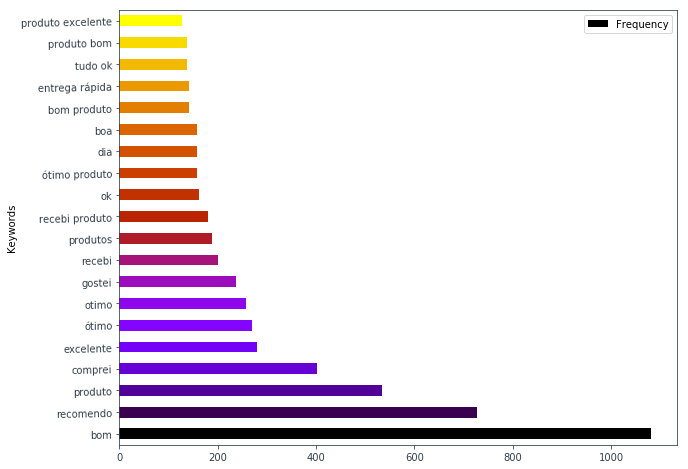

In [0]:
df_fDist = freqDistRDD.toDF() #converting RDD to spark dataframe
df_fDist.createOrReplaceTempView("myTable") 
df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 20") #renaming columns 
pandD = df2.toPandas() #converting spark dataframes to pandas dataframes
number = 20
cmap = plt.get_cmap('gnuplot') # gnuplot
colors = [cmap(i) for i in np.linspace(0, 1, number)]
pandD.plot.barh(x='Keywords', y='Frequency', color=colors, rot=1, figsize=(10,8))
plt.legend(loc='best')
plt.savefig("/content/gdrive/Shared drives/ISE467 : Project 2&3/brazilian-ecommerce/review_frequency.png", format="png")

Let us create a word cloud from the data stored in dataframe “df_fDist”.
Word cloud is a novelty visual representation of text data, typically used to depict keyword metadata (tags) on websites or to visualize free form text. Tags are usually single words, and the importance of each tag is shown with font size or color.


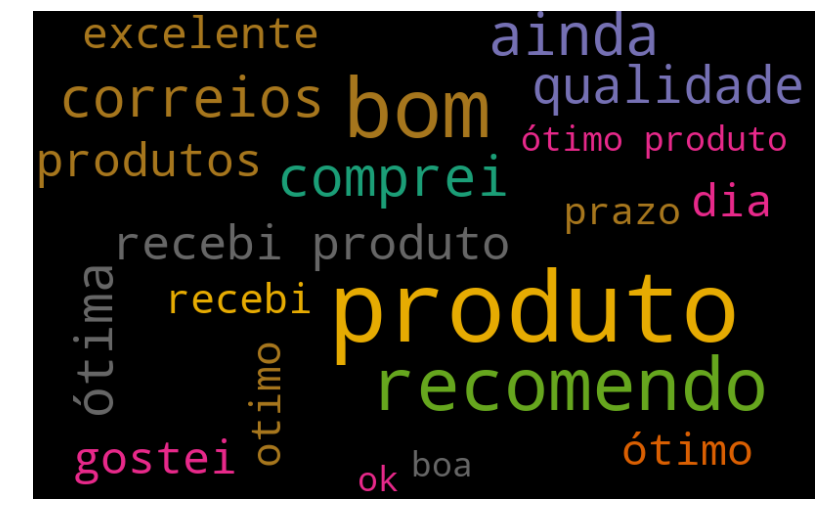

In [0]:
wordcloudConvertDF = pandD.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

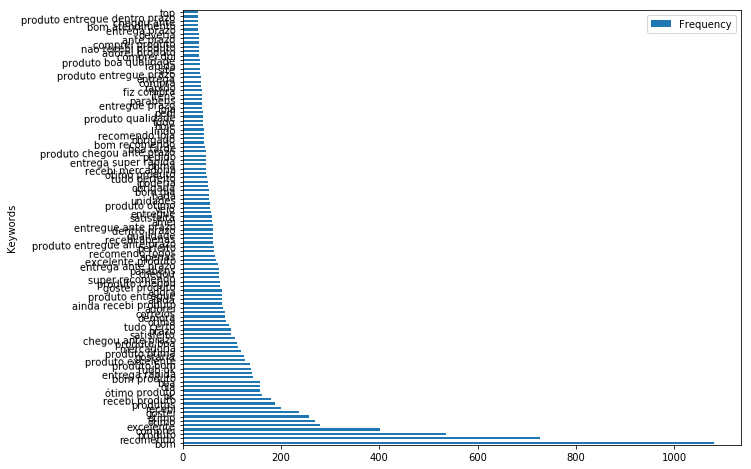

In [0]:
df_fDist = freqDistRDD.toDF() #converting RDD to spark dataframe
df_fDist.createOrReplaceTempView("myTable") 
df3 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 100") #renaming columns 
pandD2 = df3.toPandas() #converting spark dataframes to pandas dataframes
pandD2.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))

In [0]:
# Imports PIL module  
from PIL import Image
# open method used to open different extension image file 
im = Image.open(r"/content/gdrive/Shared drives/ISE467 : Project 2&3/brazilian-ecommerce/brazil_map.jpg")  
  

# This method will show image in any image viewer  
im.show()  

In [0]:
mask = np.array(Image.open("/content/gdrive/Shared drives/ISE467 : Project 2&3/brazilian-ecommerce/brazil_map.jpg"))

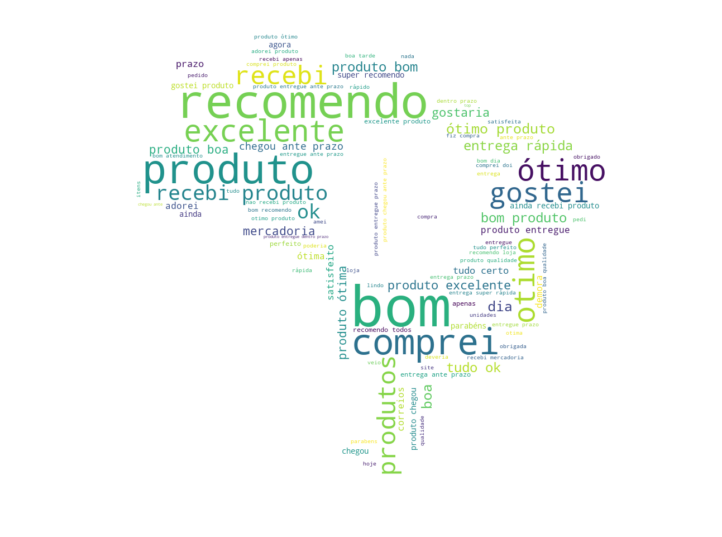

In [0]:
from wordcloud import WordCloud
wordcloudConvertDF = pandD2.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(random_state=21, max_font_size=100, relative_scaling=0.5, max_words=100, background_color="white", mask=mask).generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(12, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.savefig("/content/gdrive/Shared drives/ISE467 : Project 2&3/brazilian-ecommerce/brazil_map.png", format="png")
plt.show()

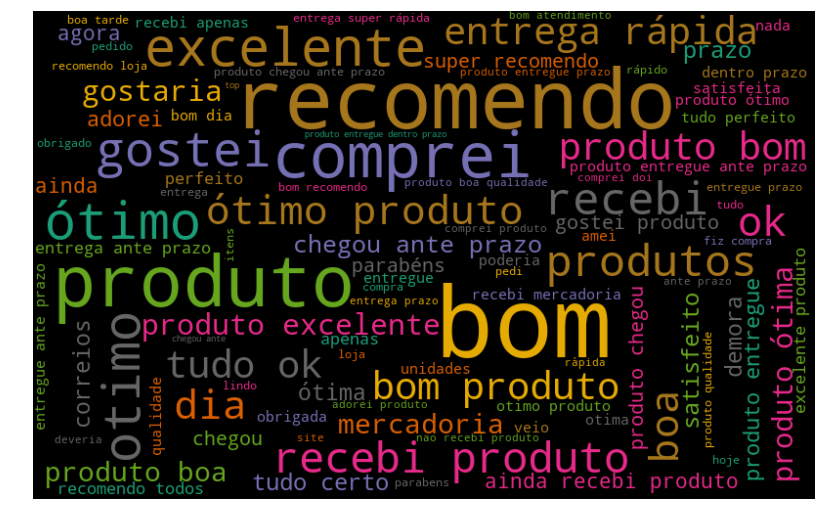

In [0]:
wordcloudConvertDF = pandD2.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

From now, we performed sentiment analysis of olist order review data set by using NLTK in Apache Spark. 